In [1]:
import pandas as pd

In [2]:
rats = pd.DataFrame({
    'contaminant': [
        6.1, 4.2, 0.5, 8.8, 1.5, 9.2, 8.5, 8.7, 6.7, 6.5, 6.3, 6.7, 0.2, 8.7, 7.5,
    ],
    'survival_time': [
        0.8, 3.5, 12.4, 1.1, 8.9, 2.4, 0.1, 0.4, 3.5, 8.3, 2.6, 1.5, 16.6, 0.1, 1.3,
    ]
})

In [3]:
import numpy as np
from scipy.optimize import root

def estimate_beta(x: np.array, y: np.array) -> np.array:
    """Estimate beta using MLE under exponential regression model.
    """
    assert len(x) == len(y), 'x and y shoud have the same length.'
    
    def score(beta):
        beta_0 = beta[0]
        beta_1 = beta[1]
        return np.array([
            len(x) - np.sum(y*np.exp(x*beta_1))*np.exp(beta_0),
            np.sum(x) - np.sum(x*y*np.exp(x*beta_1))*np.exp(beta_0)
        ])
    
    return root(score, np.array([-2.8, 0.3]))['x']
    
beta_hat = estimate_beta(rats['contaminant'].values, rats['survival_time'].values)
beta_hat

array([-2.82115025,  0.30133576])

In [4]:
beta_hat[1]

0.30133576292327585

In [5]:
from scipy import linalg

def compute_fisher_information(x: np.array, y: np.array) -> np.array:
    """Computes the Fisher information.
    
    Usually, it would depend on beta, but in this case, it cancels out.
    """
    assert len(x) == len(y), 'x and y shoud have the same length.'
    return np.array([
        [len(x), np.sum(x)],
        [np.sum(x), np.sum(x*x)]])

fisher_information = compute_fisher_information(
    rats['contaminant'].values, rats['survival_time'].values)
fisher_information

array([[ 15.  ,  90.1 ],
       [ 90.1 , 671.07]])

In [6]:
beta_hat_variance = linalg.cho_solve(
    linalg.cho_factor(fisher_information), np.eye(len(beta_hat)))
beta_hat_variance

array([[ 0.34448471, -0.04625162],
       [-0.04625162,  0.00770005]])

In [7]:
from scipy import stats

confidence_range = np.sqrt(np.diag(beta_hat_variance))*stats.norm.isf((1-0.95)/2)
confidence_range

array([1.15035813, 0.17198667])

In [8]:
print(beta_hat - confidence_range)
print(beta_hat + confidence_range)

[-3.97150839  0.12934909]
[-1.67079212  0.47332243]


In [9]:
from typing import Callable, Tuple

def make_log_likelihood(x: np.array, y: np.array) -> Callable[[np.array], float]:
    def log_likelihood(beta: np.array) -> float:
        beta_0 = beta[0]
        beta_1 = beta[1]
        return len(x)*beta_0 + np.sum(x)*beta_1 - np.exp(beta_0)*np.sum(y*np.exp(beta_1*x))
    return log_likelihood

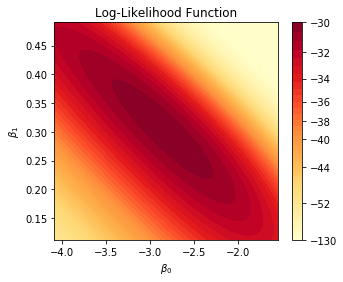

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,4))
ax = fig.gca()

def plot_log_likelihood(
    ax: plt.Axes, mesh_grid: Tuple[np.array, np.array],
    x: np.array, y: np.array) -> matplotlib.contour.QuadContourSet:    
    betas = np.stack(mesh_grid, axis=-1)
    
    log_likelihood = np.vectorize(
        make_log_likelihood(x, y), signature='(2)->()')(betas)
    
    contour_set = ax.contourf(
        mesh_grid[0], mesh_grid[1], log_likelihood,
        levels=256, cmap=plt.cm.YlOrRd,
        norm=matplotlib.colors.PowerNorm(gamma=10))
    ax.set_xlabel('$\\beta_0$')
    ax.set_ylabel('$\\beta_1$')
    ax.set_title('Log-Likelihood Function')
    return contour_set

mesh_grid = np.meshgrid(
    np.linspace(beta_hat[0] - 1.1*confidence_range[0],
                beta_hat[0] + 1.1*confidence_range[0], 100),
    np.linspace(beta_hat[1] - 1.1*confidence_range[1],
                beta_hat[1] + 1.1*confidence_range[1], 100))
    
contour_set = plot_log_likelihood(ax,
                    mesh_grid,
                    rats['contaminant'].values,
                    rats['survival_time'].values)
fig.colorbar(contour_set, spacing='proportional',
             ticks=[-130, -52, -44, -40, -38, -36, -34, -32, -30]);
fig.savefig('p2_log_likelihood.pdf', bbox_inches='tight')

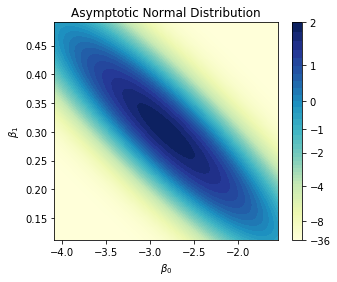

In [11]:
fig = plt.figure(figsize=(5,4))
ax = fig.gca()

def plot_asymptotic_normal(
    ax: plt.Axes, mesh_grid: Tuple[np.array, np.array],
    dist) -> matplotlib.contour.QuadContourSet: 
    betas = np.stack(mesh_grid, axis=-1)
    
    log_likelihood = np.vectorize(
        dist.logpdf, signature='(2)->()')(betas)
    
    contour_set = ax.contourf(
        mesh_grid[0], mesh_grid[1], log_likelihood,
        levels=256, cmap=plt.cm.YlGnBu,
        norm=matplotlib.colors.PowerNorm(gamma=10))
    ax.set_xlabel('$\\beta_0$')
    ax.set_ylabel('$\\beta_1$')
    ax.set_title('Asymptotic Normal Distribution')
    return contour_set

asymptotic_normal = stats.multivariate_normal(
    mean=beta_hat, cov=beta_hat_variance)
contour_set = plot_asymptotic_normal(ax, mesh_grid, asymptotic_normal)
fig.colorbar(contour_set, spacing='proportional',
             ticks=[-36, -8, -4, -2, -1, 0, 1, 2]);
fig.savefig('p2_asymptotic_normal.pdf', bbox_inches='tight')